In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dfply import *
from tableone import TableOne

In [2]:
# reading in family info and subsetting to 65+ year olds
peeps = pd.read_csv('Data/personsx.csv')
peeps = peeps.assign(_id=np.arange(len(peeps))).reset_index(drop=True)
peeps65 = peeps[(peeps['AGE_P']>=65)].copy()
peeps65.shape

(13389, 602)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1515477780>,
      dtype=object)

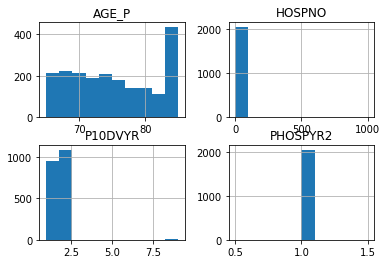

In [3]:
peeps65[['AGE_P', 'P10DVYR', 'PHOSPYR2', 'HOSPNO']].dropna().hist(sharex=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1517770f60>,
      dtype=object)

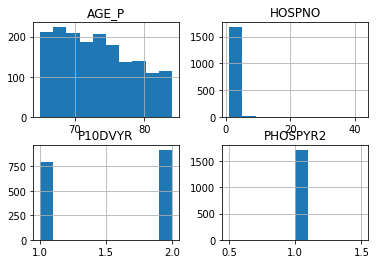

In [4]:
def remove_useless_responses(df, col, values):
    df[col] = np.where(df[col].isin(values), np.nan, df[col])
    
remove_useless_responses(peeps65, 'HOSPNO', [999])
remove_useless_responses(peeps65, 'AGE_P', [85])
remove_useless_responses(peeps65, 'P10DVYR', [7,8,9])
remove_useless_responses(peeps65, 'PHOSPYR2', [7,8,9])

peeps65[['AGE_P', 'P10DVYR', 'PHOSPYR2', 'HOSPNO']].dropna().hist()

In [5]:
# histogram was usless
peeps65['PHOSPYR2'].value_counts() 

2.0    11320
1.0     2049
Name: PHOSPYR2, dtype: int64

In [6]:
# more information in hospital nights
peeps65['HOSPNO'].describe()

count    2041.000000
mean        1.582068
std         1.620413
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        42.000000
Name: HOSPNO, dtype: float64

In [7]:
# probably want to categorize
peeps65['HOSPNO'].value_counts()

1.0     1429
2.0      369
3.0      128
4.0       57
5.0       21
6.0       16
9.0        6
7.0        5
10.0       4
14.0       2
30.0       1
42.0       1
12.0       1
8.0        1
Name: HOSPNO, dtype: int64

In [8]:
# 10 primary care visits in the last year.... this seems like a lot
peeps65['VISITS_10'] = np.nan
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 1, 1, peeps65['VISITS_10'])
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 2, 0, peeps65['VISITS_10'])

# Assuming an overnight hospital stay is an admission
peeps65['HOSPITAL_STAY'] = np.nan
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 1, 1, peeps65['HOSPITAL_STAY'])
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 2, 0, peeps65['HOSPITAL_STAY'])

peeps65['HOSPNO_CAT'] = np.nan
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 1, '1', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 2, '2', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 3, '3', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] > 3, '4 or more', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'].value_counts()

nan          11348
1             1429
2              369
3              128
4 or more      115
Name: HOSPNO_CAT, dtype: int64

### Are individuals who have 10 or more visits during the calendar year more likely to also have a hospital stay?
- Are they continually having problems?
- Are they abusing the healthcare system?
- Are they extremely proactive about their health?

In [9]:
cols_to_keep = ['_id','HOSPITAL_STAY','VISITS_10', 'AGE_P']
dat = peeps65[cols_to_keep].copy().dropna()

In [10]:
# quick crosstab
tab = pd.crosstab(dat['VISITS_10'],dat['HOSPITAL_STAY'])
tab

HOSPITAL_STAY,0.0,1.0
VISITS_10,,
0.0,8816,922
1.0,1364,798


[(0, 40),
 Text(0, 0.5, 'Hospitalization in last year (%)'),
 Text(0.5, 0, '>= 10 healthcare visits in last year')]

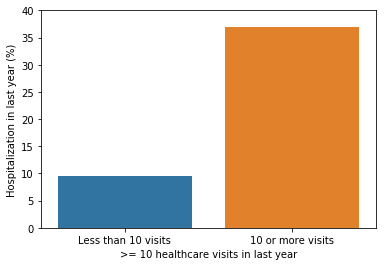

In [11]:
# Further analysis of this question regarding 10 visits and likelihood of hospital stay
pctdf = (dat >>
         mutate(COUNT = 1) >>
         group_by(X.VISITS_10, X.HOSPITAL_STAY) >>
         summarize(N = n(X.COUNT)) >>
         spread(X.HOSPITAL_STAY, X.N)
         )
pctdf.columns = ['VISITS_10', 'NO_HOSP', 'HOSP']
pctdf['PERCENT'] = round((pctdf['HOSP'] / (pctdf['NO_HOSP'] + pctdf['HOSP']))*100,2)
pctdf['VISITS_10_LAB'] = np.where(pctdf['VISITS_10'] == 1, '10 or more visits', 'Less than 10 visits')
bp = sns.barplot(x = 'VISITS_10_LAB', y = 'PERCENT', data = pctdf)
bp.set(xlabel='>= 10 healthcare visits in last year', ylabel='Hospitalization in last year (%)', ylim=(0, 40))

In [12]:
# modeling
dat['intercept'] = 1.0
train_cols = dat.columns[2:]
train_cols
logit = sm.Logit(dat['HOSPITAL_STAY'], dat[train_cols])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.373784
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          HOSPITAL_STAY   No. Observations:                11900
Model:                          Logit   Df Residuals:                    11897
Method:                           MLE   Df Model:                            2
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                 0.09521
Time:                        13:12:57   Log-Likelihood:                -4448.0
converged:                       True   LL-Null:                       -4916.1
Covariance Type:            nonrobust   LLR p-value:                5.363e-204
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VISITS_10      1.7063      0.057     30.130      0.000       1.595       1.817
AGE_P          0.0359      0.005      7.228      0.000       0.026       0.046
intercept     -4.8602      0.364    -13.358      0.000      -5.573      -4.147
==============================================================================
"""

### Among those with a hospitalization... are those with 10 or more visits more frequent users of the hospital?

In [13]:
# Further analysis on this question
cols_to_keep = ['_id', 'HOSPITAL_STAY', 'HOSPNO_CAT','VISITS_10', 'AGE_P']
dat2 = peeps65[cols_to_keep].copy()
dat2 = dat2[dat2['_id'].isin(dat._id.tolist())]
datHosp = dat2[dat2['HOSPITAL_STAY']==1].copy()

In [14]:
tab = pd.crosstab(datHosp['HOSPNO_CAT'],datHosp['VISITS_10'])
datHosp['HOSPNO_CAT'].value_counts()

1            1201
2             308
3             111
4 or more      95
nan             5
Name: HOSPNO_CAT, dtype: int64

[Text(0, 0.5, 'Percent'),
 Text(0.5, 0, 'Number of overnight stays in hospital in last year')]

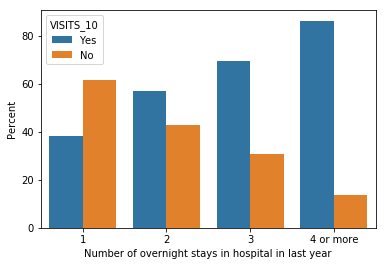

In [15]:
pctdf = (datHosp >>
         mutate(COUNT = 1) >>
         group_by(X.VISITS_10, X.HOSPNO_CAT) >>
         summarize(N = n(X.COUNT)) >>
         spread(X.VISITS_10, X.N) >>
         mask(X.HOSPNO_CAT != 'nan')
         )
pctdf.columns = ['HOSPNO_CAT', 'VISITS_10_NO', 'VISITS_10_YES']
pctdf['PERCENT_NO'] = round((pctdf['VISITS_10_NO'] / (pctdf['VISITS_10_NO'] + pctdf['VISITS_10_YES']))*100,2)
pctdf['PERCENT_YES'] = round((pctdf['VISITS_10_YES'] / (pctdf['VISITS_10_NO'] + pctdf['VISITS_10_YES']))*100,2)

# not the cleanest way to do it, but whatever
dfno = pctdf[['HOSPNO_CAT','PERCENT_NO']].copy()
dfno.columns = ['HOSPNO_CAT', 'PERCENT']
dfno['VISITS_10'] = 'No'

dfyes = pctdf[['HOSPNO_CAT','PERCENT_YES']].copy()
dfyes.columns = ['HOSPNO_CAT', 'PERCENT']
dfyes['VISITS_10'] = 'Yes'

pctdf = pd.concat([dfyes, dfno], axis = 0).reset_index(drop = True)

bp = sns.barplot(x = 'HOSPNO_CAT', y = 'PERCENT', hue = 'VISITS_10', data = pctdf)
bp.set(xlabel='Number of overnight stays in hospital in last year', ylabel='Percent')


### Notes
- idea 1... are children more likely to have a hospitalization if their parents do? Vice versa?
- idea 2... are those who receive primary/ambulatory care 10 times or more in a year less likely to have a hospitalization
- have number of times stayed in hospital overnight -- HOSPNO
- health insurance offered at workplace, yes/no -- HIEMPOF 
- received home health care -- PHCHM2W
- number of times -- PHCHMN2W
- received advice over phone -- PHCPH2WR
- number of calls -- PHCPHN2W
- went to see provider office -- PHCDV2W
- number of office visits -- PHCDVN2W
- received care 10 times -- P10DVYR
- age -- AGE_P